Copyright (c) 2024, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause 

In this notebook, we go over one advanced example to show how to use `NetworkState` APIs to execute a `cirq.Circuit` instance. As the example, we consider the Max-Cut problem and solve it with the QAOA algorithm. Details of the algorithm is available in [Cirq documentation](https://quantumai.google/cirq/experiments/qaoa/qaoa_maxcut) and [Qiskit notebook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/qaoa.ipynb).

The notebook consists of the following steps:
1. Creating the parametrized QAOA circuit.
2. Computing expectation value using `NetworkState` APIs.
3. Computing expectation value using Cirq.
4. Finding optimal parameters for both cuQuantum and Cirq.
5. Computing solutions for the optimal parameters obtained from both cuQuantum and Cirq and showing that they are equal.

In [1]:
import cirq
import numpy as np
import sympy
from scipy.optimize import minimize

from cuquantum.tensornet.experimental import NetworkState, TNConfig

np.random.seed(1)

First, we use `networkx` to generate a random regular graph as the problem graph.

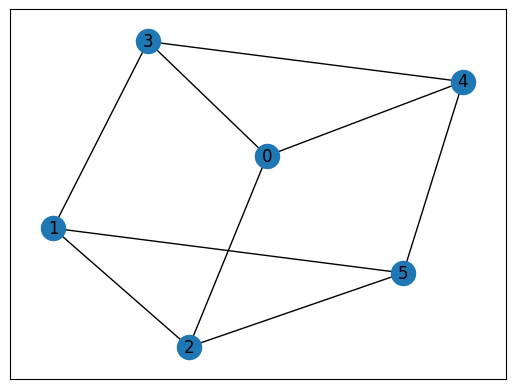

In [2]:
import networkx as nx

reg = 3
n = 6
seed = 666

graph = nx.random_regular_graph(reg, n, seed=seed)
weights = {(i, j): 1 for i, j in graph.edges}
nx.draw_networkx(graph)

Now, we create a parametrized QAOA circuit using `Cirq`.

In [3]:
def create_parametrized_qaoa_circuit(graph, n_layers):
    nqubits = len(graph.nodes())
    # Define the QAOA parameters
    gammas = [sympy.Symbol(f'gamma_{i}') for i in range(n_layers)]
    betas = [sympy.Symbol(f'beta_{i}') for i in range(n_layers)]

    qubits = [cirq.GridQubit(i, 0) for i in range(nqubits)]
    circuit = cirq.Circuit()
    # Initial layer of Hadamard gates
    circuit.append(cirq.H.on_each(*qubits))

    # QAOA layers
    for i in range(n_layers):
        # Cost Hamiltonian (ZZ interactions)
        for edge in graph.edges:
            circuit.append(cirq.ZZ(*[qubits[edge[0]], qubits[edge[1]]]) ** gammas[i])
        # Mixer Hamiltonian (X rotations)
        circuit.append(cirq.rx(2 * betas[i]).on_each(*qubits))

    # Measurement
    circuit.append(cirq.measure(*qubits, key='result'))

    return circuit

p = 4 # depth
n_layers = p//2  # number of QAOA layers
qaoa_circuit = create_parametrized_qaoa_circuit(graph, n_layers)
n_qubits = len(qaoa_circuit.all_qubits())
print(qaoa_circuit)

                                                                                  ┌────────────────────┐                                                                                                                   ┌────────────────────┐
(0, 0): ───H───ZZ───────────ZZ───────────ZZ───────────Rx(2*beta_0)──────────────────────────────────────────────────────────────────────────────────────ZZ───────────ZZ───────────ZZ───────────Rx(2*beta_1)──────────────────────────────────────────────────────────────────────────────────────M('result')───
               │            │            │                                                                                                              │            │            │                                                                                                              │
(1, 0): ───H───┼────────────┼────────────┼────────────ZZ─────────────ZZ────────────ZZ──────────────────────Rx(2*beta_0)─────────────────────────────────┼──────────

Now, we bind parameters with random numbers. This helps us to parse them in `NetworkState`.

In [4]:
def compute_binded_qaoa_circuit(qaoa_circuit, theta):
    n_layers = len(theta)//2  # number of QAOA layers
    param_values = {f'gamma_{i}': theta[i] for i in range(n_layers)} | {f'beta_{i}': theta[n_layers + i] for i in range(n_layers)}
    binded_qaoa_circuit = cirq.resolve_parameters(qaoa_circuit, param_values)
    return binded_qaoa_circuit

Then, we compute expectations for `NetworkState` and `Cirq` using sampling

In [5]:
def count_overlap(graph, n_qubits, bitstring):
    if isinstance(bitstring, int):
        bitstring = str(format(bitstring, f'0{n_qubits}b'))
    overlap = 0
    for i, j in graph.edges():
        if bitstring[i] != bitstring[j]:
            overlap -= 1
    return overlap


def samples_to_expectation(graph, n_qubits, sampling):
    expec = 0
    nshots = 0
    for bitstring, counts in sampling.items():
        nshots += counts
        expec += count_overlap(graph, n_qubits, bitstring) * counts
    return expec / nshots


def compute_cutn(qaoa_circuit, graph, shots=1000):
    nqubits = len(graph.nodes())
    config = TNConfig(num_hyper_samples=4)
    
    def execute_circuit(theta):    
        qc = compute_binded_qaoa_circuit(qaoa_circuit, theta)
        with NetworkState.from_circuit(qc, dtype='complex128', config=config, backend='cupy') as state:
            samples = state.compute_sampling(shots, seed=23)
            e = samples_to_expectation(graph, nqubits, samples)
        return e
    return execute_circuit


def compute_cirq(qaoa_circuit, graph, shots=1000):
    simulator = cirq.Simulator(seed=10)
    n_qubits = len(qaoa_circuit.all_qubits())
    def execute_circuit(theta):
        qc = compute_binded_qaoa_circuit(qaoa_circuit, theta)
        result = simulator.run(qc, repetitions=shots)
        counts = result.histogram(key='result')
        return samples_to_expectation(graph, n_qubits, counts)
    return execute_circuit

expectation_cutn = compute_cutn(qaoa_circuit, graph, shots=1000)
expectation_cirq = compute_cirq(qaoa_circuit, graph, shots=1000)

Now, we use `scipy.optimize` to find the optimal parameters (theta) for the two different backends by optimizing the expectation value.

In [6]:
theta = list(np.random.random(p))

result_cutn_sampling = minimize(expectation_cutn, theta, method='COBYLA')
print(f"Optimal results from NetworkState with sampling: \n{result_cutn_sampling}\n")

result_cirq = minimize(expectation_cirq, theta, method='COBYLA')
print(f"Optimal results from Cirq sampling: \n{result_cirq}")

Optimal results from NetworkState with sampling: 
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.008
       x: [ 1.691e-01  1.018e+00 -1.910e-02  3.384e-01]
    nfev: 55
   maxcv: 0.0

Optimal results from Cirq sampling: 
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.251
       x: [ 3.310e-01  8.762e-01  1.527e-01  4.735e-01]
    nfev: 56
   maxcv: 0.0


Finally, we analyze the results from the two backends using the internal simulator of `Cirq`, and print the top ten results that show we have 6 solutions for this problem.

In [7]:
def get_top_results_from_theta(graph, theta, n_top, shots=1000):
    simulator = cirq.Simulator(seed=10)
    resolver = cirq.ParamResolver({f'gamma_{i}': theta[i] for i in range(n_layers)} |
                              {f'beta_{i}': theta[n_layers + i] for i in range(n_layers)})
    final_result_cirq = simulator.run(qaoa_circuit, param_resolver=resolver, repetitions=shots)
    final_counts_cirq = final_result_cirq.histogram(key='result')
    sols = sorted(final_counts_cirq.items(), key=lambda item: -item[1])[:n_top]
    return [bitstring for bitstring, _ in sols]


n_top = 10  # find the top 10 solutions
shots = 1000
bitstrings_cutn = get_top_results_from_theta(graph, result_cutn_sampling.x, n_top, shots=shots)
bitstrings_cirq = get_top_results_from_theta(graph, result_cirq.x, n_top, shots=shots)

sol_cutn = {}

print(f'Top {n_top} solutions from cuTensorNet sampling')
for bitstring in bitstrings_cutn:
    bitstring = format(bitstring, f'0{n_qubits}b')
    sol_cutn[bitstring] = count_overlap(graph, n_qubits, bitstring)
    print(bitstring,  sol_cutn[bitstring])
    
print('\n')
sol_cirq = {}
print(f'Top {n_top} solutions from Cirq')
for bitstring in bitstrings_cirq:
    bitstring = format(bitstring, f'0{n_qubits}b')
    sol_cirq[bitstring] = count_overlap(graph, n_qubits, bitstring)
    print(bitstring, sol_cirq[bitstring])

Top 10 solutions from cuTensorNet sampling
110001 -7
001101 -7
110010 -7
001110 -7
011010 -7
100101 -7
000101 -6
100001 -6
110100 -5
111000 -5


Top 10 solutions from Cirq
110001 -7
001101 -7
011010 -7
001110 -7
110010 -7
100101 -7
000101 -6
110000 -6
110100 -5
100001 -6


In this particular example, there are 6 bitstrings reaching the minimum, and cuTensorNet and Cirq should return the same set of best answers that we check with `assert`.

In [8]:
min_sol_cutn = [bitstring for bitstring, val in sol_cutn.items() if val == min(sol_cutn.values())]
min_sol_cirq = [bitstring for bitstring, val in sol_cutn.items() if val == min(sol_cirq.values())]
assert set(min_sol_cutn) == set(min_sol_cirq)